# Implementation 

In [21]:

import numpy as np
from numpy.linalg import norm
from time import time

In [22]:
def kernel_cost(gamma, data, reg):

    KX2 = data['KX2']
    KY2 = data['KY2']
    KX3 = data['KX3']
    KY3 = data['KY3']

    tmp1 = np.mean(KX3) + np.mean(KY3)
    tmp2 = (np.mean(KX2, axis=0) + np.mean(KY2, axis=0)) @ gamma
    c = (tmp1 - tmp2) / (2 * reg)

    return c


In [23]:
def gradient(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the gradient of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        g_gamma (np.ndarray): m*1 vector.
        g_X (np.ndarray): m*m matrix.
    """
    m = len(z)
    H = Phi.T @ X @ Phi
    g_gamma = (Q @ gamma - z) / (2 * reg2) - np.diag(H)
    g_X = Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m)
    return g_gamma, g_X


In [24]:
def residue(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the residue of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        r_gamma (np.ndarray): m*1 vector.
        r_X (np.ndarray): m*m matrix.
    """
    # Compute the gradient
    g_gamma, g_X = gradient(gamma, X, Phi, Q, z, reg1, reg2)  
    X_new = X - g_X
    V, D = np.linalg.eig(X_new)
    X_new = V @ np.maximum(D, 0) @ V.T
    r_gamma = gamma - g_gamma
    r_X = X - X_new
    
    return r_gamma, r_X


In [25]:
def build_A_matrix(Phi):
    '''
    Given a matrix Phi, this function constructs the matrix A as given in page 8 of the article.
    '''
    n = Phi.shape[1]

    # Initialize the A matrix with appropriate size
    A = np.zeros((n, n*n))

    # Build the L matrix
    for i in range(n):
        col_i = Phi[:, i]  # Select column i of Phi
        A[i, :] = np.ravel(np.kron(col_i.T, col_i.T))
    return A


In [48]:
def SSN_main(r_gamma, r_X, gamma, X, mu, Q, Phi, reg1, reg2):
    m = len(gamma)

    # The first step
    Z = X - (Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m))
    Sigma, P = np.linalg.eigh(Z)
    Sigma = Sigma[::-1]
    P = P[:, ::-1]
    alpha = np.where(np.diag(Sigma) > 0)[0]
    beta = np.where(np.diag(Sigma) <= 0)[0]
    Omega = np.zeros((m, m))
    Omega[np.ix_(alpha, alpha)] = np.ones(len(alpha))
    eta = 1 - np.outer(sigma[beta], 1/sigma[alpha])
    eta = 1 / eta
    Omega[np.ix_(alpha, beta)] = eta
    Omega[np.ix_(beta, alpha)] = eta.T
    L = Omega / (mu + 1 - Omega)

    T = r_X + P @ (L * (P.T @ r_X @ P)) @ P.T
    H = Phi.T @ T @ Phi
    d_gamma = - r_gamma - np.diag(H) / (1 + mu)
    d_X = -r_X

    # The second step (CG)
    y = d_gamma
    K = P.T @ Phi
    H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
    r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
    p = r
    rr = r.T @ r
    for i in range(min(m // 5, 50)):
        H = K.T @ (L * (K @ np.diag(p) @ K.T)) @ K
        Ap = (0.5 / reg2) * Q @ p + mu * p + np.diag(H)
        ss1 = rr / (p.T @ Ap)
        y += ss1 * p
        r -= ss1 * Ap
        if np.linalg.norm(r) < 1e-6:
            break
        ss2 = r.T @ r / rr
        p = r + ss2 * p
        H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
        r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
        rr = r.T @ r
    d_gamma = y
    d_X = (d_X + P @ (L * (P.T @ d_X @ P)) @ P.T) / (1 + mu)

    # The third step
    d_X -= P @ (L * (K @ np.diag(d_gamma) @ K.T)) @ P.T

    return d_gamma, d_X

In [ ]:
def SSN_main(r_gamma, r_X, gamma, X, mu, Q, Phi, reg1, reg2, A):
    """
    Compute the SSN step.

    Args:
        r_gamma (np.ndarray): m*1 vector.
        r_X (np.ndarray): m*m matrix.
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        mu (float): Scalar.
        Q (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        d_gamma (np.ndarray): m*1 vector.
        d_X (np.ndarray): m*m matrix.
    """
    m = len(gamma)

    # First step
    # Calcul de Z
    Z = X - (Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m))


    sigma, P = np.linalg.eigh(Z)
    alpha = sigma[sigma > 0]
    beta = sigma[sigma <= 0]
    n = len(alpha)

   # Construction de la matrice Omega
    Omega = np.zeros((m, m))
    Omega[:n, :n] = 1 
    eta = alpha[:, np.newaxis] / (alpha[:, np.newaxis] - beta)
    Omega[:n, n:] = eta  
    Omega[n:, :n] = eta.T  

    diagonal = np.ravel(Omega.T)
    L = np.diag(diagonal) / (mu + 1 - diagonal)

    Psi = np.zeros((m, m))
    eps = eta/(mu+1-eta)
    Psi[:n, :n] = (1/mu)*np.ones((n, n))
    Psi[:n, n:] = eps 
    Psi[n:, :n] = eps.T
    
    # Calcul de a1 et a2 (d_gamma, d_X) 
    T = r_X + P @ (Psi * (P.T @ r_X @ P)) @ P.T 
    H = Phi.T @ T @ Phi
    d_gamma = -r_gamma - np.diag(H) / (1 + mu)
    d_X = -r_X



    # Second step (CG)
    d_X = (d_X + P @ (Psi * (P.T @ d_X @ P)) @ P.T ) / (1 + mu)
    
    P_ = np.kron(P, P)
    M_ = 0.5 * Q/reg2 + mu * np.eye(m) + A @ (P_ @ L @ P_.T) @ A.T
    x_0 = d_gamma
    r = d_gamma - M_ @ x_0 
    p = r
    rr = r @ r.T
    for _ in range(min(m // 5, 50)):
        Ap = M_ @ p
        ss1 = rr / (p @ Ap.T)
        x_0 = x_0 + ss1 * p
        r = r - ss1 * Ap
        print("residu", np.linalg.norm(r))
        if np.linalg.norm(r) < 1e-6:
            break
        ss2 = r @ r.T / rr
        p = r + ss2 * p
        rr = r @ r.T
    d_gamma = x_0
    

    # Third step
    phi_start_a1 = Phi @ np.diag(d_gamma) @ Phi.T
    d_X = d_X - (P @ (Psi * (P.T @ phi_start_a1@ P)) @ P.T)

    return d_gamma, d_X


In [27]:
def SSN(data, reg1, reg2, verbose):
    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M
    nIter = 1000

    gamma = np.ones(m) /m
    X = np.ones((m, m)) /(m*m)
    kappa = 1.0
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = norm(r_gamma) + norm(r_X, 'fro')
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')

    tstart = time()

    # Main loop
    for iter in range(1, nIter + 1):
        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')

        # Compute SSN step
        d_gamma, d_X = SSN_main(r_gamma, r_X, gamma, X, (m / 5) * kappa * mu, Q, Phi, reg1, reg2)

        # Compute the next iterate
        gamma += d_gamma
        X += d_X

        # Update the parameter kappa
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
        rho = -(np.dot(r_gamma, d_gamma) + np.trace(np.dot(r_X.T, d_X))) / (norm(d_gamma) ** 2 + norm(d_X, 'fro') ** 2)
        if rho >= 1:
            kappa = max(0.5 * kappa, 1e-16)
        elif rho >= 1e-6:
            kappa = 1.2 * kappa
        else:
            kappa = 25 * kappa

        if mu < 1e-8:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 2 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')

        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm

# Experiments

In [28]:
%matplotlib inline

import numpy as np
from scipy.stats import norm as norms

import ot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Quasi-random sequences
from sobol_seq import i4_sobol_generate

### Kernel SoS OT functions
from optim import interior_point
from utils import make_kernels, transport_cost, transport_1D, potential_1D

In [29]:
nfill = 100
nsamples = 100

In [30]:
n = 2000

mu1 = [0.7, 0.3]
mu2 = [0.2, 0.5, 0.75]


t1 = [0.4, 0.6]
t2 = [0.2, 0.2, 0.6]

x = np.linspace(0, 1, n)
    
r_tmp = []    
for mode in mu1:
    r_tmp.append(norms.pdf(x,mode, 0.09))
        
c_tmp = []    
for mode in mu2:
    c_tmp.append(norms.pdf(x,mode, 0.075))
        
mu = np.dot(t1,r_tmp)
nu = np.dot(t2,c_tmp)

In [31]:
np.random.seed(123)

u1 = np.random.rand(nsamples)
u2 = np.random.rand(nsamples)

X = np.zeros(nsamples)
Y = np.zeros(nsamples)

for i in range(nsamples):
    if u1[i] < t1[0]:
        X[i] = np.random.randn() * .1 + mu1[0]
    else:
        X[i] = np.random.randn() * .1 + mu1[1]
    if u2[i] < t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[0]
    elif u2[i] < t2[1] + t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[1]
    else:
        Y[i] = np.random.randn() * .075 + mu2[2]

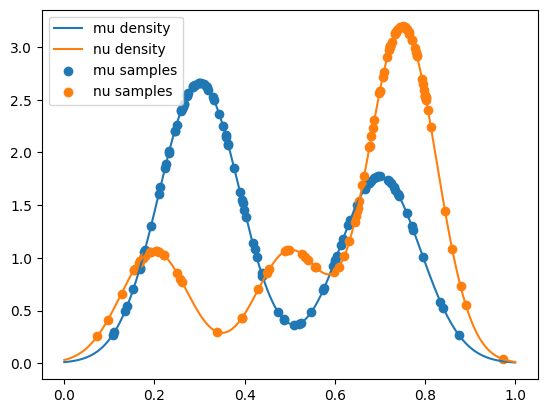

In [32]:
x = np.linspace(0, 1, n)

f, ax = plt.subplots()

ax.plot(x, mu, label = 'mu density')
ax.plot(x, nu, label = 'nu density')

ax.scatter(X, mu[(n * X).astype(int)], label = 'mu samples')
ax.scatter(Y, nu[np.minimum((n * Y).astype(int), n-1)], label = 'nu samples')


plt.legend()
plt.show()

In [33]:
### Sobol quasi-random samples to fill the space X x Y. 
sob = i4_sobol_generate(2 , nfill, skip = 3000)


## Add some points in the corners (optional)
sob = np.insert(sob, 0, np.array([1e-2, 1e-2]))
sob = np.insert(sob, 0, np.array([1-1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1.-1e-2, 1e-2]))

sob = sob.reshape(-1, 2)[:-4 , :]


X_fill = sob[:, :1]
Y_fill = sob[:, 1:] 

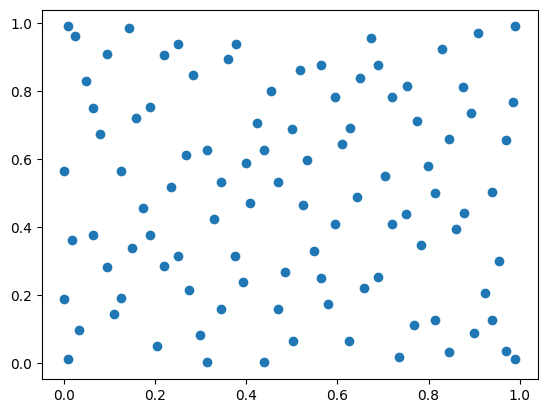

In [34]:
plt.scatter(X_fill, Y_fill)

In [35]:
kernel = 'gaussian'
l = .1
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

In [36]:
data = {}
data["Phi"] = Phi
data["KX1"] = Kx1
data["KX2"] = Kx2
data["KX3"] = Kx3
data["KY1"] = Ky1
data["KY2"] = Ky2
data["KY3"] = Ky3
data["M"] = M


In [37]:
## Regularization parameters

lbda_1 = 1 / nfill
lbda_2 =  1 / nsamples


## Optimization problem parameters

eps_start = nfill
eps_end = 1e-8

tau = 1e-8

niter = 1000

In [40]:
Z = np.array([[1, 2, 3], [2, 2, 4], [3, 4, 0]])
m = 3

In [45]:
alpha

array([2], dtype=int64)

In [43]:
Sigma, P = np.linalg.eigh(Z)
alpha = np.where(np.diag(Sigma) > 0)[0]
beta = np.where(np.diag(Sigma) <= 0)[0]
print(Sigma)
print(alpha)
Omega = np.zeros((m, m))
Omega[np.ix_(alpha, alpha)] = np.ones(len(alpha))
sigma = np.diag(Sigma)
eta = 1 - np.outer(sigma[beta], 1/sigma[alpha])
eta = 1 / eta
Omega[np.ix_(alpha, beta)] = eta
Omega[np.ix_(beta, alpha)] = eta.T
L = Omega / (mu + 1 - Omega)

[-3.52810771 -0.55984211  7.08794983]
[2]


C:\Users\frank\AppData\Local\Temp\ipykernel_3796\1379949099.py:9: RuntimeWarning: divide by zero encountered in divide
  eta = 1 - np.outer(sigma[beta], 1/sigma[alpha])
c:\Users\frank\.conda\envs\Pythonbest\Lib\site-packages\numpy\core\numeric.py:925: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
C:\Users\frank\AppData\Local\Temp\ipykernel_3796\1379949099.py:10: RuntimeWarning: divide by zero encountered in divide
  eta = 1 / eta


ValueError: shape mismatch: value array of shape (24,3) could not be broadcast to indexing result of shape (1,8)

In [38]:
gamma, c, t, res_time, res_norm = SSN(data, lbda_1, lbda_2, True)


-------------- SSNEG ---------------
iter |  cost  |  residue  |  time


ValueError: shape mismatch: value array of shape (1000000,0) could not be broadcast to indexing result of shape (0,10000)